<a href="https://colab.research.google.com/github/tl0909/SMUBIA-Datathon---Daytar/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [1]:
!pip install pycountry
!pip install geopandas

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import os
import re
import spacy
from spacy.matcher import Matcher
import pycountry
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import geopandas as gpd
import matplotlib.pyplot as plt

# Load spaCy's English model
nlp = spacy.load('en_core_web_sm')

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('vader_lexicon')

stop_words = set(stopwords.words('english'))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 33.1 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Upload Data**

In [4]:
source1 = '/content/drive/My Drive/Datathon(SMUISD)/news_excerpts_parsed.xlsx'
source2 = '/content/drive/My Drive/Datathon(SMUISD)/wikileaks_parsed.xlsx'

news_excerpts = pd.read_excel(source1)
wikileaks = pd.read_excel(source2)

# Display the first few rows
print(news_excerpts.head())
print(wikileaks.head())

                                                Link  \
0  https://edition.cnn.com/2023/09/29/business/st...   
1  https://www.channelnewsasia.com/singapore/su-w...   
2  https://edition.cnn.com/2023/05/22/tech/meta-f...   
3  https://www.channelnewsasia.com/singapore/bill...   
4  https://edition.cnn.com/2024/03/05/politics/li...   

                                                Text  
0  Starbucks violated federal labor law when it i...  
1  The first suspect to plead guilty in Singapore...  
2  Meta has been fined a record-breaking €1.2 bil...  
3  SINGAPORE: A 45-year-old man linked to Singapo...  
4  The Department of Education imposed a record $...  
  PDF Path                                               Text
0    1.pdf  Pristina Airport – Possible administrative irr...
1    1.pdf  Investigative details\n\nIn his/her interviews...
2   10.pdf  "An interoffice memorandum providing an “outst...
3   10.pdf  "Allegation 2 & 3:\n\n(Specifically, three of ...
4   10.pdf  "When asked

# **Data Cleaning**

In [5]:
## Combining the same pdf to the same text for wikileaks
combined_wikileaks = wikileaks.groupby('PDF Path', as_index=False).agg({
    'Text': ' '.join  # Concatenate text with a space
})

text_data1 = news_excerpts["Text"]
text_data2 = combined_wikileaks["Text"]

# Pre process the text
def preprocess_text(text):
    if pd.isna(text):  # Handle missing values
        return ""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\n|\r', ' ', text)  # Replace newline characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = ' '.join(word for word in word_tokenize(text) if word not in stop_words)  # Remove stopwords
    return text
# Create a new data frame for processed text data
processed_text_data1 = pd.DataFrame()
processed_text_data2 = pd.DataFrame()
processed_text_data1['Text'] = text_data1
processed_text_data2['Text'] = text_data2
processed_text_data1['Text Processed'] = text_data1.apply(preprocess_text)
processed_text_data2['Text Processed'] = text_data2.apply(preprocess_text)

# Add Source Column to Identify Origin of the Text
processed_text_data1['Source'] = 'Articles'
processed_text_data2['Source'] = 'WikiLeaks'

# **Data Processing**

**1st Step: Predefined Keyword Classification**

In [6]:
# Define Classification Logic
economic_keywords = ['economic', 'money', 'trade', 'investment', 'cash', 'payment', 'transaction', 'funds', 'theft', 'robbery', 'embezzlement', 'asset', 'valuable', 'gold', 'jewellery', 'bank', 'fraud', 'scam', 'embezzle', 'extortion', 'ransom']
violence_keywords = ["injury", "death", "discrimination", "assault", "murder", "homicide", "kidnap", "arson", "terror", "vandalism", "trespassing", "drug", "illegal", "data", "breach", "cyber"]

def classify_crime(text):
    # Check if any economic keyword exists in the text
    if any(keyword in text for keyword in economic_keywords):
        return 'Economic/Trade/Money-related'
    elif any(keyword in text for keyword in violence_keywords):
        return 'Non-money-related'
    else:
        return 'None'

processed_text_data1['Crime_Type'] = processed_text_data1['Text Processed'].apply(classify_crime)
processed_text_data2['Crime_Type'] = processed_text_data2['Text Processed'].apply(classify_crime)

# Print the counts
print("News", processed_text_data1['Crime_Type'].value_counts())
print("Wiki", processed_text_data2['Crime_Type'].value_counts())
print(processed_text_data1[['Text', 'Crime_Type']].head())
print(processed_text_data2[['Text', 'Crime_Type']].head())

News Crime_Type
None                            937
Economic/Trade/Money-related    406
Non-money-related               166
Name: count, dtype: int64
Wiki Crime_Type
Economic/Trade/Money-related    32
None                            10
Non-money-related                2
Name: count, dtype: int64
                                                Text  \
0  Starbucks violated federal labor law when it i...   
1  The first suspect to plead guilty in Singapore...   
2  Meta has been fined a record-breaking €1.2 bil...   
3  SINGAPORE: A 45-year-old man linked to Singapo...   
4  The Department of Education imposed a record $...   

                     Crime_Type  
0                          None  
1  Economic/Trade/Money-related  
2             Non-money-related  
3  Economic/Trade/Money-related  
4             Non-money-related  
                                                Text  \
0  Pristina Airport – Possible administrative irr...   
1  "An interoffice memorandum providing an “outst.

**2nd Step: Extraction of Entities (Country)**

Note: the text used to analyse is the unprocessed one as the library did not really work well with the processed one ;-;

In [7]:
# Extracting Countries using spaCy and filtering with pycountry
# Function to find a country by name, alpha codes, or demonym
def find_country(entity):
    entity_lower = entity.lower()

    for country in pycountry.countries:
        # Check official name, common name, alpha codes
        if (
            entity_lower == country.name.lower() or
            entity_lower == getattr(country, 'official_name', '').lower() or
            entity_lower in [country.alpha_2.lower(), country.alpha_3.lower()]
        ):
            return country.name

        # Check demonyms (e.g., Indonesian → Indonesia)
        if hasattr(country, 'demonym') and entity_lower == country.demonym.lower():
            return country.name

    # If no match, return None
    return None

# Enhanced function using spaCy and pycountry
def extract_countries_spacy(text):
    doc = nlp(text)
    countries = set()

    for ent in doc.ents:
        if ent.label_ in ['GPE', 'NORP', 'LOC']:  # GPE, nationalities, or locations
            country_name = find_country(ent.text.strip())
            if country_name:
                countries.add(country_name)

    return ', '.join(sorted(countries)) if countries else 'None'

# Apply country extraction
processed_text_data1['Countries'] = processed_text_data1['Text'].apply(extract_countries_spacy)
processed_text_data2['Countries'] = processed_text_data2['Text'].apply(extract_countries_spacy)

# Display the results with extracted countries
print(processed_text_data1[['Text', 'Crime_Type', 'Countries']].head())
print(processed_text_data2[['Text', 'Crime_Type', 'Countries']].head())

                                                Text  \
0  Starbucks violated federal labor law when it i...   
1  The first suspect to plead guilty in Singapore...   
2  Meta has been fined a record-breaking €1.2 bil...   
3  SINGAPORE: A 45-year-old man linked to Singapo...   
4  The Department of Education imposed a record $...   

                     Crime_Type  Countries  
0                          None       None  
1  Economic/Trade/Money-related  Singapore  
2             Non-money-related       None  
3  Economic/Trade/Money-related  Singapore  
4             Non-money-related       None  
                                                Text  \
0  Pristina Airport – Possible administrative irr...   
1  "An interoffice memorandum providing an “outst...   
2  "Description\n\nThis is a Secret US National S...   
3  "Tokyo's Climate Change Officials to Continue ...   
4  "Description\n\nThis is a secret US National S...   

                     Crime_Type                         

In [8]:
# Dictionary of capital cities mapped to countries
capital_to_country = {
    'vienna': 'Austria',
    'paris': 'France',
    'berlin': 'Germany',
    'washington': 'United States',
    'london': 'United Kingdom',
    # Add more capitals as needed
}

# Dictionary of country abbreviations mapped to full country names
abbreviation_to_country = {
    'us': 'United States',
    'uk': 'United Kingdom',
    'de': 'Germany',
    'fr': 'France',
    # Add more abbreviations as needed
}

# Enhanced function to find country, considering capitals and abbreviations
def find_country(entity):
    entity_lower = entity.lower()

    # First check if the entity is a known capital city
    if entity_lower in capital_to_country:
        return capital_to_country[entity_lower]

    # Then check if the entity is a known country abbreviation
    if entity_lower in abbreviation_to_country:
        return abbreviation_to_country[entity_lower]

    # Default check for pycountry countries
    for country in pycountry.countries:
        if (
            entity_lower == country.name.lower() or
            entity_lower == getattr(country, 'official_name', '').lower() or
            entity_lower in [country.alpha_2.lower(), country.alpha_3.lower()]
        ):
            return country.name

        # Check demonyms (e.g., Indonesian → Indonesia)
        if hasattr(country, 'demonym') and entity_lower == country.demonym.lower():
            return country.name

    # If no match, return None
    return None

# Enhanced function using spaCy and pycountry
def extract_countries_spacy(text):
    doc = nlp(text)
    countries = set()

    for ent in doc.ents:
        if ent.label_ in ['GPE', 'NORP', 'LOC']:  # GPE, nationalities, or locations
            country_name = find_country(ent.text.strip())
            if country_name:
                countries.add(country_name)

    return ', '.join(sorted(countries)) if countries else 'None'

# Apply country extraction
processed_text_data1['Countries'] = processed_text_data1['Text'].apply(extract_countries_spacy)
processed_text_data2['Countries'] = processed_text_data2['Text'].apply(extract_countries_spacy)

# Display the results with extracted countries
print(processed_text_data1[['Text', 'Crime_Type', 'Countries']].head())
print(processed_text_data2[['Text', 'Crime_Type', 'Countries']].head())


KeyboardInterrupt: 

**3rd Step: LinearSVC using Labelled Data to Predict 'None' Types**

In [9]:
# Combine both processed datasets
combined_data = pd.concat([
    processed_text_data1[['Source', 'Text Processed', 'Text', 'Countries', 'Crime_Type']],
    processed_text_data2[['Source', 'Text Processed', 'Text', 'Countries', 'Crime_Type']]
])

# Feature Extraction with TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Separate training data (excluding "None") and data with "None" for later prediction
train_data = combined_data[combined_data['Crime_Type'] != 'None']
none_data = combined_data[combined_data['Crime_Type'] == 'None']

# **Step 1: Balance the Dataset by Undersampling**
# Find the smallest class count
min_class_count = train_data['Crime_Type'].value_counts().min()

# Randomly sample an equal number of rows from each class
balanced_data = train_data.groupby('Crime_Type').apply(
    lambda x: x.sample(min_class_count, random_state=42)
).reset_index(drop=True)

# Check class distribution
print("Balanced class distribution:")
print(balanced_data['Crime_Type'].value_counts())

# **Step 2: Train the Model**
# Split the balanced data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    balanced_data['Text Processed'], balanced_data['Crime_Type'],
    test_size=0.2, random_state=42
)

# Transform text data into TF-IDF features
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Define a function to tune the model
def tune_model(X, y):
    param_grid = {'C': [0.1, 1, 10], 'max_iter': [1000, 2000, 3000]}
    svc = LinearSVC(random_state=42)
    grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
    grid_search.fit(X, y)
    print(f"Best parameters found: {grid_search.best_params_}")
    return grid_search.best_estimator_

# Train the model with GridSearchCV
model = tune_model(X_train_vec, y_train)

# Evaluate on test data
y_pred = model.predict(X_test_vec)
print("Classification report on test data:")
print(classification_report(y_test, y_pred))

# **Step 3: Predict Crime Types for 'None' Data**
# Transform 'None' data using the same vectorizer
none_data_features = vectorizer.transform(none_data['Text Processed'])

# Predict labels for 'None' data
predicted_labels = model.predict(none_data_features)

# Assign predictions back to the original none_data
none_data.loc[:, 'Crime_Type'] = predicted_labels

# **Step 4: Update Combined Dataset with Predictions**
for index, none_row in none_data.iterrows():
    # Match by 'Text Processed' to update original combined data
    matching_rows = combined_data[combined_data['Text Processed'] == none_row['Text Processed']]
    if not matching_rows.empty:
        combined_index = matching_rows.index[0]
        combined_data.at[combined_index, 'Crime_Type'] = none_row['Crime_Type']

# Check the updated Crime_Type counts
print("Updated class distribution in the combined dataset:")
print(combined_data['Crime_Type'].value_counts())

Balanced class distribution:
Crime_Type
Economic/Trade/Money-related    168
Non-money-related               168
Name: count, dtype: int64
Fitting 3 folds for each of 9 candidates, totalling 27 fits


<ipython-input-9-40af28f2da55>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = train_data.groupby('Crime_Type').apply(


Best parameters found: {'C': 10, 'max_iter': 1000}
Classification report on test data:
                              precision    recall  f1-score   support

Economic/Trade/Money-related       0.90      0.76      0.82        37
           Non-money-related       0.76      0.90      0.82        31

                    accuracy                           0.82        68
                   macro avg       0.83      0.83      0.82        68
                weighted avg       0.84      0.82      0.82        68

Updated class distribution in the combined dataset:
Crime_Type
Non-money-related               802
Economic/Trade/Money-related    751
Name: count, dtype: int64


**Method 2: NLP using spaCy**

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
file_path = '/content/drive/My Drive/Datathon(SMUISD)/news_excerpts_parsed.xlsx'

df = pd.read_excel(file_path)

# Display the first few rows
print(df.head())

In [ ]:
# Define crime-related keywords for filtering specific issues
non_money_crime_keywords = ["assault", "murder", "terrorism", "kidnap", "homicide",
                            "illegal", "threat", "safety", "terror", "arson", "vandalism",
                            "trespassing", "drug", "data", "breach", "personal data", "data protection", "cyber"]

money_crime_keywords = ["money", "cash", "payment", "transaction", "funds", "theft", "launder", "laundering",
                        "robbery", "embezzlement","asset", "valuable", "gold", "jewelry", "bank",
                        "fraud", "scam", "embezzle", "extortion"]

# Process each row in the 'Text' column
results = []
for text in df["Text"]:
    if pd.notna(text):  # Ensure text is not NaN
        doc = nlp(text)  # Process the text with SpaCy

        # Extract only GPE and NORP entities
        entities = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ["GPE", "NORP"]]

        # Extract potential issues/crimes by filtering verbs/nouns related to crime
        non_money_crime = [
            token.text for token in doc
            if token.pos_ in ["VERB", "NOUN"] and
               any(keyword in token.text.lower() for keyword in non_money_crime_keywords)
        ]

        money_crime = [
            token.text for token in doc
            if token.pos_ in ["VERB", "NOUN"] and
               any(keyword in token.text.lower() for keyword in money_crime_keywords)
        ]

        # Append the results for each text entry
        results.append({"Text": text, "Entities": entities, "Non Money Crime": non_money_crime, "Money Crime": money_crime})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Save to a new Excel file
output_file = "analyzed_results_specific.xlsx"
results_df.to_excel(output_file, index=False)
print(f"Analysis complete. Results saved to {output_file}.")


**Sentiment Analysis**

In [10]:
#analyse sentiment using VADER on cleaned data

sia = SentimentIntensityAnalyzer()

#analyse_sentiment function
def analyse_sentiment(text):
  #handles empty strings by assignining them as neutral
  if not text or text.strip() == "":
    return {"Positive":0.0, "Neutral":1.0, "Negative":0.0, "Compound":0.0, "Sentiment": "Neutral"}
  scores = sia.polarity_scores(text)
  #extracts overall sentiment score
  compound = scores['compound']
  if compound >= 0.05:
    sentiment = "Positive"
  elif compound <= -0.05:
    sentiment = "Negative"
  else:
    sentiment = "Neutral"
  #classifies sentiment based on above threshold
  scores["Sentiment"] = sentiment
  return scores

#applying sentiment analysis on news excerpts
#processed_text_data1[['Positive', 'Neutral', 'Negative', 'Compound', 'Sentiment']] = processed_text_data1['Text Processed'].apply(
  #lambda x: pd.Series(analyse_sentiment(x)))
#applying sentiment analysis on wikileak excerpts
#processed_text_data2[['Positive', 'Neutral', 'Negative', 'Compound', 'Sentiment']] = processed_text_data2['Text Processed'].apply(
  #lambda x: pd.Series(analyse_sentiment(x)))

# Apply on combined data
combined_data[['Positive', 'Neutral', 'Negative', 'Compound', 'Sentiment']] = combined_data['Text Processed'].apply(
  lambda x: pd.Series(analyse_sentiment(x)))

print(combined_data.head())

     Source                                     Text Processed  \
0  Articles  starbucks violated federal labor law increased...   
1  Articles  first suspect plead guilty singapores largest ...   
2  Articles  meta fined recordbreaking billion billion euro...   
3  Articles  singapore yearold man linked singapores larges...   
4  Articles  department education imposed record million fi...   

                                                Text  Countries  \
0  Starbucks violated federal labor law when it i...       None   
1  The first suspect to plead guilty in Singapore...  Singapore   
2  Meta has been fined a record-breaking €1.2 bil...       None   
3  SINGAPORE: A 45-year-old man linked to Singapo...  Singapore   
4  The Department of Education imposed a record $...       None   

                     Crime_Type  Positive  Neutral  Negative  Compound  \
0             Non-money-related     0.149    0.720     0.130   -0.3612   
1  Economic/Trade/Money-related     0.254    0.681  

# **Analysis of Data**

Just trying out

<Figure size 1500x1000 with 0 Axes>

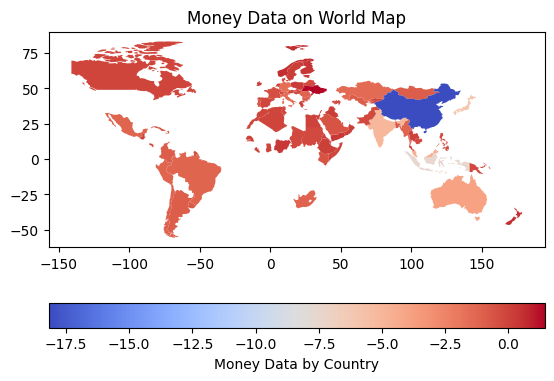

<Figure size 1500x1000 with 0 Axes>

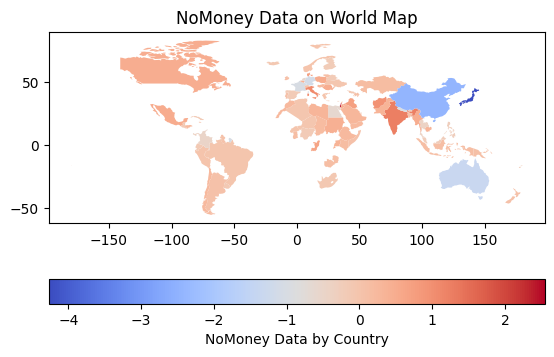

In [11]:
# List of related countries (to Singapore)
related_countries = ['Malaysia', 'Indonesia', 'Brunei', 'Thailand', 'Vietnam', 'Philippines']

# Ensure the 'Countries' column is split into a list of countries
combined_data['Countries'] = combined_data['Countries'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

# Now 'Countries' is a list for each row, and you can continue processing
threat_scores_money = {}
threat_scores_nomoney = {}

def append_threat_score(countriesfunc, countryfunc, score, dictionary):
    if countryfunc == 'None' or countryfunc == 'Singapore':
        return dictionary
    if countryfunc not in dictionary:
        dictionary[countryfunc] = 0
    if 'Singapore' in countriesfunc:
        dictionary[countryfunc] -= score
    elif country in related_countries:
        dictionary[countryfunc] -= score * 0.5
    else:
        dictionary[countryfunc] -= score * 0.25
    return dictionary

# Loop through each row of the combined_data DataFrame
for _, row in combined_data.iterrows():
    countries = row['Countries']  # List of countries
    compound_score = row['Compound']  # Sentiment score for the row
    crime_type = row['Crime_Type']

    for country in countries:  # Iterate over the countries in the list
        if crime_type == 'Economic/Trade/Money-related':
            threat_scores_money = append_threat_score(countries, country, compound_score, threat_scores_money)
        else:
            threat_scores_nomoney = append_threat_score(countries, country, compound_score, threat_scores_nomoney)

# Print the final threat scores for each country
#print("Money", threat_scores_money)
#print("NoMoney", threat_scores_nomoney)

# Combine Money and NoMoney data into separate dataframes
df_money = pd.DataFrame(list(threat_scores_money.items()), columns=['Country', 'Money']).set_index('Country')
df_nomoney = pd.DataFrame(list(threat_scores_nomoney.items()), columns=['Country', 'NoMoney']).set_index('Country')

world_map_file = '/content/drive/My Drive/Datathon(SMUISD)/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'

# Load the world map
world = gpd.read_file(world_map_file)

# Merge the world map with the Money data
world = world.set_index('NAME').join(df_money)

# Plot the Money data
plt.figure(figsize=(15, 10))
ax = world.plot(column='Money', cmap='coolwarm', legend=True,
                legend_kwds={'label': "Money Data by Country",
                             'orientation': "horizontal"})
plt.title('Money Data on World Map')
plt.show()

# Load the world map again for the NoMoney data plot
world = gpd.read_file(world_map_file)

# Merge the world map with the NoMoney data
world = world.set_index('NAME').join(df_nomoney)

# Plot the NoMoney data
plt.figure(figsize=(15, 10))
ax = world.plot(column='NoMoney', cmap='coolwarm', legend=True,
                legend_kwds={'label': "NoMoney Data by Country",
                             'orientation': "horizontal"})
plt.title('NoMoney Data on World Map')
plt.show()